In [27]:
import os
import sys
sys.path.append('../src/')
import glob
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 101)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm import tqdm

import cca_functions

# configurations
- select microscopy folder in first step
- select positions of the selected folder in second step
- repeat to add more positions to the analysis

In [35]:
data_dirs, positions = cca_functions.configuration_dialog()

In [36]:
file_names = [os.path.split(path)[-1] for path in data_dirs]
channels = ['phase_contr', 'mCitrine']
no_of_channels = len(channels)
image_folders = [[os.path.join(data_dir, pos_str, 'Images') for pos_str in pos_list] for pos_list, data_dir in zip(positions, data_dirs)]

# load data and perform all needed calculations on image data
(no need to keep all image data in memory at once, load it, calculate stuff, drop it)

In [45]:
overall_df = pd.DataFrame()
for file_idx, file in enumerate(file_names):
    for pos_idx, pos_dir in enumerate(image_folders[file_idx]):
        channel_data = ('placeholder')*no_of_channels
        print(f'Load files for {file}, {positions[file_idx][pos_idx]}...')
        *channel_data, seg_mask, cc_data, cc_props = cca_functions.load_files(pos_dir, channels)
        print(f'Number of cells in position: {len(cc_data.Cell_ID.unique())}')
        print(f'Number of annotated frames in position: {cc_data.frame_i.max()+1}')
        cc_data = cca_functions.rename_columns(cc_data)
        max_frame = cc_data.frame_i.max()
        if cc_props is not None:
            print('Cell Cycle property data already existing, loaded from disk...')
            overall_df = overall_df.append(cc_props)
        else:
            print(f'Calculate regionprops on each frame based on Segmentation...')
            rp_df = cca_functions.calculate_rp_df(seg_mask[:max_frame+1])
            print(f'Calculate mean signal strength for every channel and cell...')
            flu_signal_df = cca_functions.calculate_flu_signal(seg_mask, channel_data, channels, cc_data)
            temp_df = cc_data.merge(rp_df, on=['frame_i', 'Cell_ID'], how='left')
            temp_df = temp_df.merge(flu_signal_df, on=['frame_i', 'Cell_ID'], how='left')
            temp_df['max_frame_pos'] = cc_data.frame_i.max()
            temp_df['file'] = file
            temp_df['selection_subset'] = file_idx
            temp_df['position'] = positions[file_idx][pos_idx]
            temp_df['directory'] = pos_dir
            print('Saving calculated data for next time...')
            save_path = os.path.join(pos_dir, f's{positions[file_idx][pos_idx]}_cca_properties_downstream.csv')
            temp_df.to_csv(save_path, index=False)    
            overall_df = overall_df.append(temp_df).reset_index(drop=True)

Load files for MIA_F016.nd2, Position_1...


  3%|██▋                                                                               | 4/124 [00:00<00:03, 35.36it/s]

Number of cells in position: 26
Number of annotated frames in position: 124
Calculate regionprops on each frame based on Segmentation...


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [00:06<00:00, 18.87it/s]


Calculate mean signal strength for every channel and cell...


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:07<00:00,  3.70it/s]


Saving calculated data for next time...
Load files for MIA_F016.nd2, Position_2...


  4%|██▉                                                                                | 3/84 [00:00<00:02, 29.90it/s]

Number of cells in position: 21
Number of annotated frames in position: 84
Calculate regionprops on each frame based on Segmentation...


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:05<00:00, 16.05it/s]


Calculate mean signal strength for every channel and cell...


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  5.09it/s]


Saving calculated data for next time...
Load files for MIA_F016.nd2, Position_3...


  0%|                                                                                          | 0/128 [00:00<?, ?it/s]

Number of cells in position: 21
Number of annotated frames in position: 128
Calculate regionprops on each frame based on Segmentation...


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.66it/s]


Calculate mean signal strength for every channel and cell...


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:24<00:00,  1.19s/it]


Saving calculated data for next time...
Load files for MIA_F016.nd2, Position_4...


  0%|                                                                                          | 0/113 [00:00<?, ?it/s]

Number of cells in position: 26
Number of annotated frames in position: 113
Calculate regionprops on each frame based on Segmentation...


100%|████████████████████████████████████████████████████████████████████████████████| 113/113 [00:19<00:00,  5.94it/s]


Calculate mean signal strength for every channel and cell...


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:26<00:00,  1.00s/it]


Saving calculated data for next time...
Load files for MIA_F016.nd2, Position_5...


  1%|▊                                                                                  | 1/97 [00:00<00:12,  7.71it/s]

Number of cells in position: 26
Number of annotated frames in position: 97
Calculate regionprops on each frame based on Segmentation...


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [00:19<00:00,  4.94it/s]


Calculate mean signal strength for every channel and cell...


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:23<00:00,  1.12it/s]


Saving calculated data for next time...
Load files for MIA_F016.nd2, Position_6...


  4%|███▍                                                                              | 5/120 [00:00<00:02, 42.22it/s]

Number of cells in position: 30
Number of annotated frames in position: 120
Calculate regionprops on each frame based on Segmentation...


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:08<00:00, 13.41it/s]


Calculate mean signal strength for every channel and cell...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.88it/s]

Saving calculated data for next time...


In [46]:
overall_df

,frame_i,Cell_ID,is_cell_dead,is_cell_excluded,x_centroid,y_centroid,editIDclicked_x,editIDclicked_y,editIDnewID,cell_cycle_stage,generation_num,relative_ID,relationship,emerg_frame_i,division_frame_i,cell_area_pxl,cell_vol_vox,cell_area_um2,cell_vol_fl,area,convex_area,filled_area,major_axis_length,minor_axis_length,orientation,perimeter,centroid_y,centroid_x,solidity,2d_label_count,min_t,max_t,lifespan,age,frames_till_gone,elongation,phase_contr_corrected_mean_signal,mCitrine_corrected_mean_signal,max_frame_pos,file,selection_subset,position,directory
0,0,1,False,False,372,341,NaN,NaN,-1,S,0.0,2.0,bud,-1.0,-1.0,2009,66141.169,0.201,0.066,2009,2032,2009,51.940,49.398,-1.302,164.468,341.269,371.503,0.989,1.0,0,123,124,1,123,1.051,1088.554,584.000,123,MIA_F016.nd2,0,Position_1,C:/Users/mairhoermann/Documents/phd-code/Yeast...
1,0,2,False,False,320,353,NaN,NaN,-1,S,2.0,1.0,mother,-1.0,-1.0,2984,106578.281,0.298,0.107,2984,3022,2984,70.984,53.766,-0.545,204.409,353.058,319.672,0.987,1.0,0,123,124,1,123,1.320,906.284,392.752,123,MIA_F016.nd2,0,Position_1,C:/Users/mairhoermann/Documents/phd-code/Yeast...
2,1,1,False,False,372,342,NaN,NaN,-1,S,0.0,2.0,bud,-1.0,-1.0,2075,69012.428,0.207,0.069,2075,2107,2075,52.898,50.116,-1.120,168.125,341.531,371.748,0.985,1.0,0,123,124,2,122,1.056,1020.272,527.754,123,MIA_F016.nd2,0,Position_1,C:/Users/mairhoermann/Documents/phd-code/Yeast...
3,1,2,False,False,319,354,NaN,NaN,-1,S,2.0,1.0,mother,-1.0,-1.0,3031,109453.041,0.303,0.109,3031,3077,3031,71.367,54.341,-0.559,207.823,353.645,319.498,0.985,1.0,0,123,124,2,122,1.313,873.425,404.530,123,MIA_F016.nd2,0,Position_1,C:/Users/mairhoermann/Documents/phd-code/Yeast...
4,2,1,False,False,372,341,NaN,NaN,-1,S,0.0,2.0,bud,-1.0,-1.0,2158,73187.331,0.216,0.073,2158,2202,2158,53.985,51.016,-1.124,173.782,340.826,372.115,0.980,1.0,0,123,124,3,121,1.058,1021.687,542.303,123,MIA_F016.nd2,0,Position_1,C:/Users/mairhoermann/Documents/phd-code/Yeast...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345,119,27,False,False,558,237,NaN,NaN,-1,S,0.0,4.0,bud,115.0,-1.0,1024,22287.675,0.102,0.022,1024,1052,1024,39.888,32.771,-1.552,119.397,237.278,557.681,0.973,1.0,115,119,5,5,0,1.217,1114.407,577.305,119,MIA_F016.nd2,1,Position_6,C:/Users/mairhoermann/Documents/phd-code/Yeast...
6346,119,28,False,False,518,132,NaN,NaN,-1,S,0.0,14.0,bud,115.0,-1.0,389,5536.025,0.039,0.006,389,399,389,23.372,21.426,0.787,72.184,131.817,517.591,0.975,1.0,115,119,5,5,0,1.091,1103.105,608.488,119,MIA_F016.nd2,1,Position_6,C:/Users/mairhoermann/Documents/phd-code/Yeast...
6347,119,29,False,False,595,343,NaN,NaN,-1,S,0.0,16.0,bud,116.0,-1.0,300,3579.298,0.030,0.004,300,309,300,21.422,18.049,-1.041,63.355,342.933,594.750,0.971,1.0,116,119,4,4,0,1.187,275.850,1295.303,119,MIA_F016.nd2,1,Position_6,C:/Users/mairhoermann/Documents/phd-code/Yeast...
6348,119,31,False,False,241,216,NaN,NaN,-1,S,0.0,6.0,bud,117.0,-1.0,292,3516.506,0.029,0.004,292,303,292,20.896,18.040,1.294,63.456,215.784,241.147,0.964,1.0,117,119,3,3,0,1.158,2017.476,723.469,119,MIA_F016.nd2,1,Position_6,C:/Users/mairhoermann/Documents/phd-code/Yeast...


In [47]:
for channel in channels:
    overall_df[f'{channel}_corrected_signal_amount'] = overall_df[f'{channel}_corrected_mean_signal'] *\
    overall_df['area']

In [48]:
# calculate area of daughter cell where applicable
overall_df['daughter_area'] = 0
daughter_areas = overall_df.merge(
    overall_df, how='left', 
    left_on=['relative_ID', 'frame_i', 'position', 'file'],
    right_on=['Cell_ID', 'frame_i', 'position', 'file']
)['area_y']
daughter_indices= np.logical_and(~daughter_areas.isna(),overall_df['relationship']=='mother')
overall_df.loc[daughter_indices,'daughter_area'] = daughter_areas[daughter_indices]

In [57]:
# build dataframe grouped by phases
phase_grouped = overall_df.groupby(['Cell_ID', 'generation_num', 'cell_cycle_stage', 'position', 'file']).agg(
    growth_in_phase=('area', lambda x: max(x)-min(x)),
    phase_length=('frame_i', lambda x: max(x)-min(x)),
    area_at_beginning=('area', lambda x: x.iloc[0]),
    daughter_growth=('daughter_area', lambda x: max(x)-min(x)),
    phase_begin = ('frame_i', min),
    phase_end = ('frame_i', max),
    max_frame_pos = ('max_frame_pos', 'first'),
    selection_subset = ('selection_subset', 'first')
).reset_index()

In [58]:
# detect incomplete cell cycle stages and incomplete cell cycles
incomplete_phase_indices = np.logical_or(
    phase_grouped.phase_begin==0,
    phase_grouped.phase_end==phase_grouped.max_frame_pos
)
no_of_phases_per_cycle = phase_grouped.groupby(
    ['Cell_ID', 'generation_num', 'position', 'file']
)['cell_cycle_stage'].transform('count')
incomplete_cycle_indices = no_of_phases_per_cycle < 2
phase_grouped['incomplete_phase'] = incomplete_phase_indices.astype(int)
phase_grouped['incomplete_cycle'] = incomplete_cycle_indices.astype(int)
phase_grouped['all_complete'] = np.logical_and(~incomplete_phase_indices, ~incomplete_cycle_indices).astype(int)

In [59]:
phase_grouped.head()

,Cell_ID,generation_num,cell_cycle_stage,position,file,growth_in_phase,phase_length,area_at_beginning,daughter_growth,phase_begin,phase_end,max_frame_pos,selection_subset,incomplete_phase,incomplete_cycle,all_complete
0,1,0.0,S,Position_1,MIA_F016.nd2,415,9,2009,0.0,0,9,123,0,1,1,0
1,1,0.0,S,Position_2,MIA_F016.nd2,921,18,1157,0.0,0,18,83,0,1,1,0
2,1,0.0,S,Position_3,MIA_F016.nd2,830,12,1204,0.0,0,12,127,0,1,1,0
3,1,1.0,G1,Position_1,MIA_F016.nd2,270,6,2481,106.0,10,16,123,0,0,0,1
4,1,1.0,G1,Position_2,MIA_F016.nd2,657,17,2095,299.0,19,36,83,0,0,0,1


# generate plots / analyses on obtained data

## G1 vs. S duration (1st generation)

Text(0.5, 1.0, 'G1 duration vs. S duration within same generation')

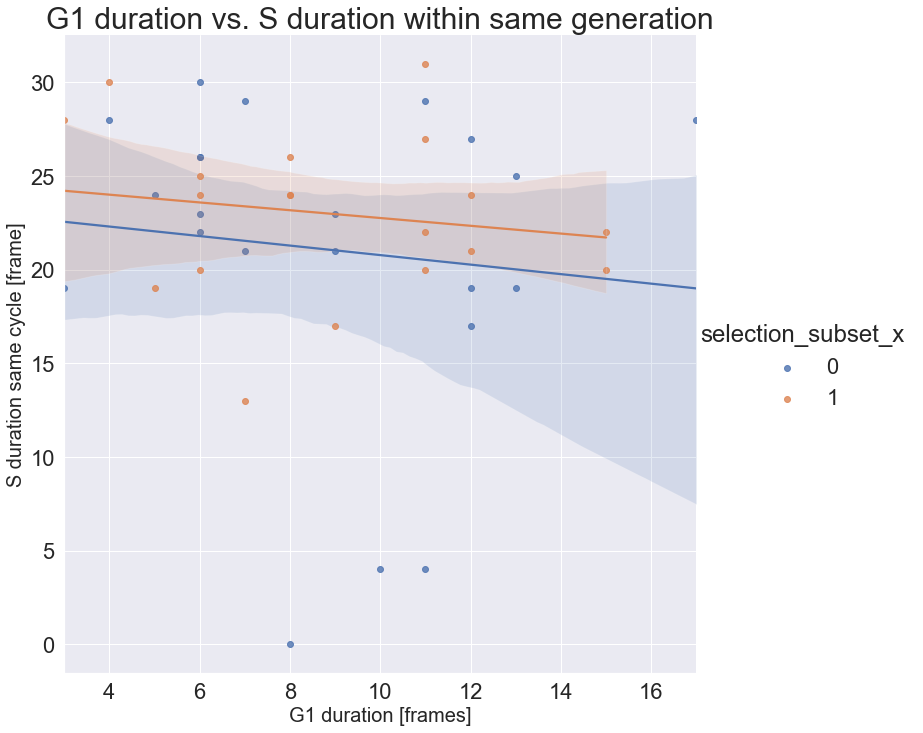

In [64]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
complete_cc_data = phase_grouped[phase_grouped.all_complete==1]
s_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="S"]
g1_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="G1"]
plot_data1 = g1_data.merge(s_data, on=['Cell_ID', 'generation_num', 'position', 'file'], how='inner')
plot_data1 = plot_data1[plot_data1.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
sns.lmplot(x="phase_length_x", y="phase_length_y", data=plot_data1,
    hue="selection_subset_x", height=10)
ax = plt.gca()
ax.set_ylabel("S duration same cycle [frame]", fontsize=20)
ax.set_xlabel("G1 duration [frames]", fontsize=20)
ax.set_title("G1 duration vs. S duration within same generation", fontsize=30)

## growth in G1 vs. mother+daughter growth in S (1st generation)

Text(0.5, 1.0, 'G1 growth vs. mother+daughter cell S growth')

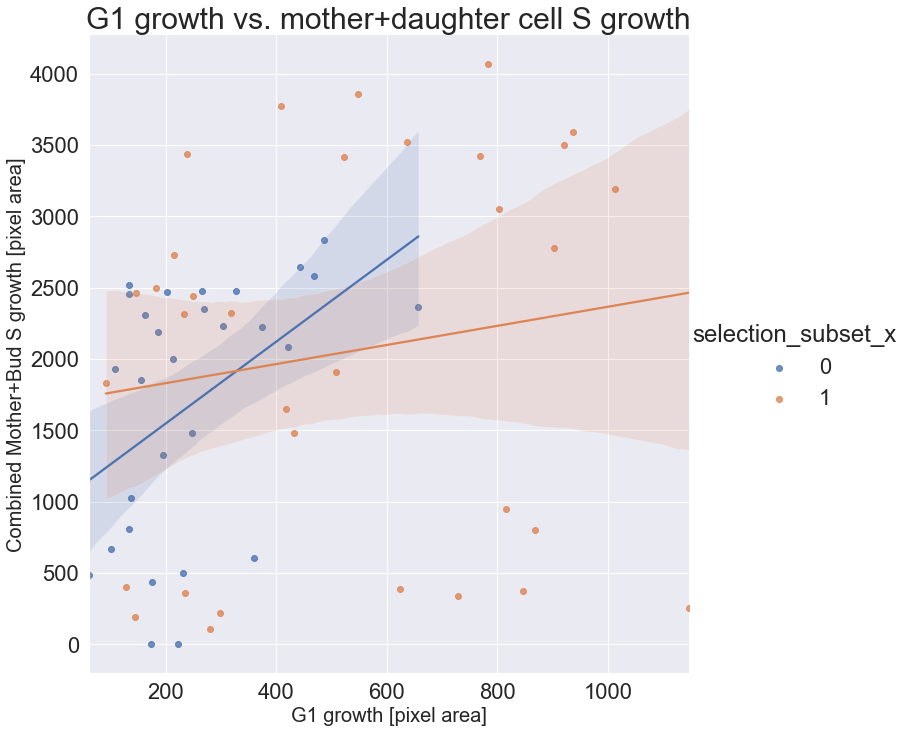

In [66]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
complete_cc_data = phase_grouped[phase_grouped.incomplete_cycle==0]
s_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="S"]
g1_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="G1"]
plot_data2 = g1_data.merge(s_data, on=['Cell_ID', 'generation_num', 'position'], how='inner')
plot_data2 = plot_data2[plot_data2.generation_num==1]
plot_data2['combined_motherbud_growth'] = plot_data2['growth_in_phase_y'] + plot_data2['daughter_growth_y']

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
sns.lmplot(x="growth_in_phase_x", y="combined_motherbud_growth", data=plot_data2,
    hue="selection_subset_x", height=10)
ax = plt.gca()
ax.set_ylabel("Combined Mother+Bud S growth [pixel area]", fontsize=20)
ax.set_xlabel("G1 growth [pixel area]", fontsize=20)
ax.set_title("G1 growth vs. mother+daughter cell S growth", fontsize=30)

## Size at birth vs. G1 growth (1st generation)
- only first generation or all?

Text(0.5, 1.0, 'Size at birth vs G1 duration (1st generation)')

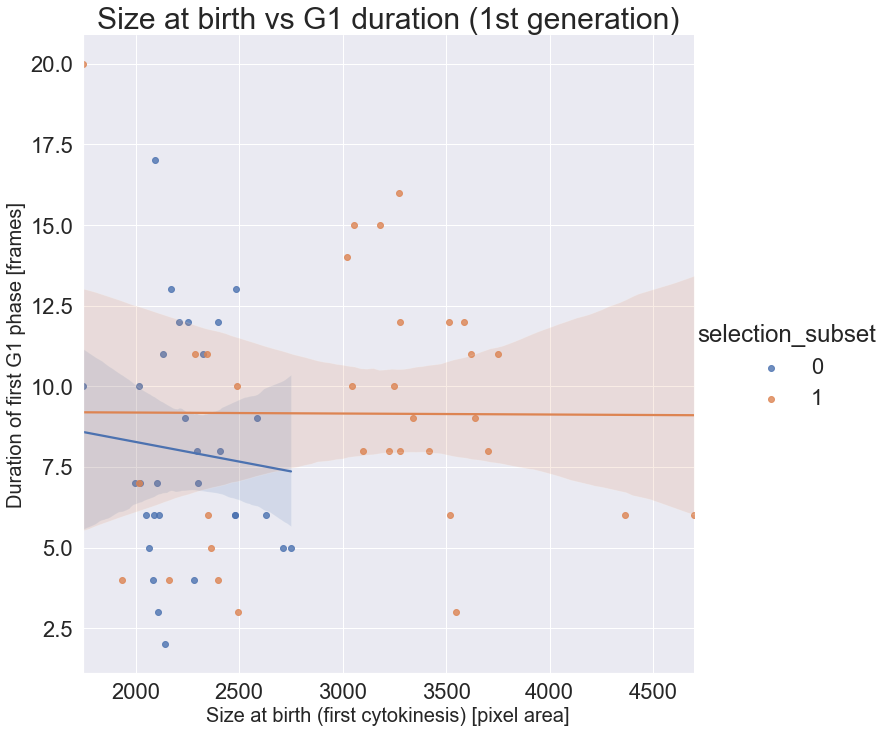

In [67]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
plot_data3 = phase_grouped[phase_grouped.cell_cycle_stage=="G1"]
plot_data3 = plot_data3[plot_data3.incomplete_phase==0]
plot_data3 = plot_data3[plot_data3.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
sns.lmplot(x="area_at_beginning", y="phase_length", data=plot_data3,
    hue="selection_subset", height=10)
ax = plt.gca()
ax.set_ylabel("Duration of first G1 phase [frames]", fontsize=20)
ax.set_xlabel("Size at birth (first cytokinesis) [pixel area]", fontsize=20)
ax.set_title("Size at birth vs G1 duration (1st generation)", fontsize=30)

## Flurescence Signal over time
### TODO:
- calculate signal strength on cell border (more interesting for Cdc10)
- build groups of positions to compare with each other

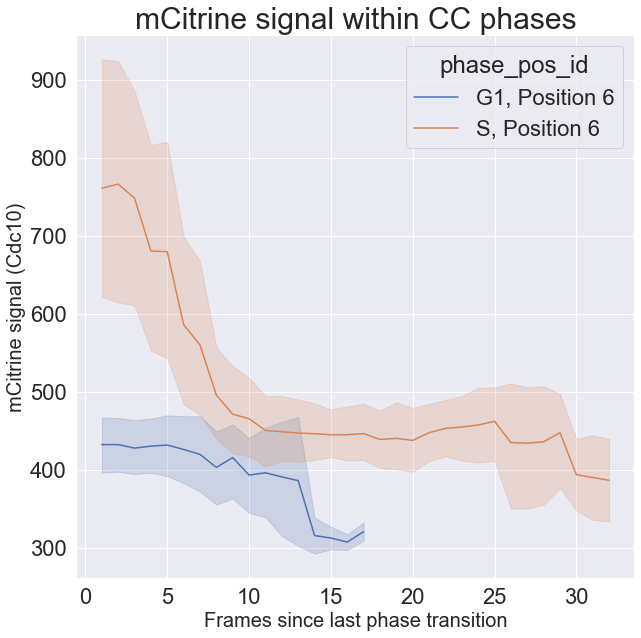

In [36]:
plot_data3 = overall_df.copy()

plot_data3['frames_in_phase'] = plot_data3.sort_values(['frame_i'], ascending=True)\
             .groupby(['position', 'Cell_ID', 'cell_cycle_stage', 'generation_num'])\
             .cumcount() + 1
plot_data3['phase_pos_id'] = plot_data3.apply(lambda x: str(x.loc['cell_cycle_stage'])+', '+'Position '+str(x.loc['position']), axis=1)

f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(data=plot_data3.sort_values('phase_pos_id'), x="frames_in_phase", y="mCitrine_corrected_mean_signal", 
             hue='selection_su')
ax.set_ylabel("mCitrine signal (Cdc10)", fontsize=20)
ax.set_xlabel("Frames since last phase transition", fontsize=20)
ax.set_title("mCitrine signal within CC phases", fontsize=30)
plt.show()

# backup

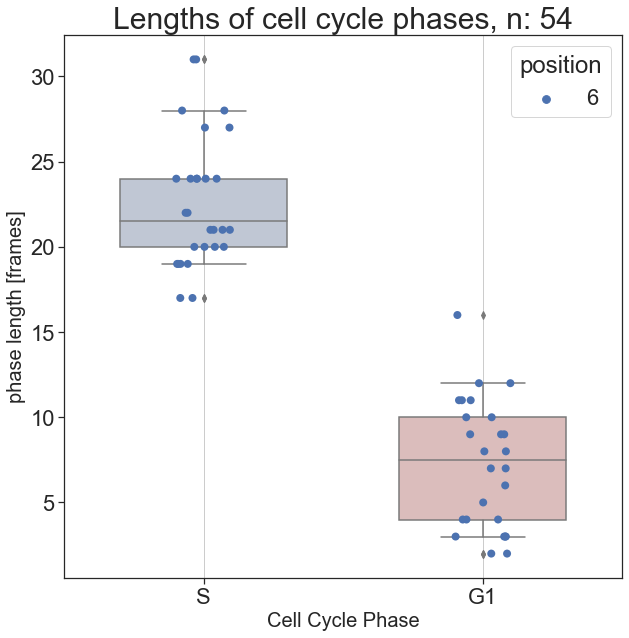

In [156]:
plot_data1 = phase_grouped[~incomplete_phase_indices]
sns.set_theme(style="ticks", font_scale=2)

# Initialize the figure
f, ax = plt.subplots(figsize=(10, 10))
# Plot the orbital period with horizontal boxes
sns.boxplot(x="cell_cycle_stage", y="phase_length", data=plot_data1,
            whis=[5, 95], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x="cell_cycle_stage", y="phase_length", data=plot_data1,
              size=8, hue="position", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set_ylabel("phase length [frames]", fontsize=20)
ax.set_xlabel("Cell Cycle Phase", fontsize=20)
ax.set_title(f"Lengths of cell cycle phases, n: {plot_data1.shape[0]}", fontsize=30)
#sns.despine(trim=True, left=True)
plt.show()

In [144]:
# code for calculating column "phase transition (boolean)"
"""
plot_data3['cell_pos_id'] = plot_data3.apply(lambda x: str(x.loc['Cell_ID'])+'-'+str(x.loc['position']), axis=1)

plot_data3['phase_transition'] = 0
for i in plot_data3.cell_pos_id.unique():
    sc_data = plot_data3.loc[plot_data3.cell_pos_id==i]
    phase_transition_indices = sc_data['cell_cycle_stage'] != sc_data['cell_cycle_stage'].shift(1)
    sc_data.loc[phase_transition_indices, 'phase_transition'] = 1
    plot_data3.loc[plot_data3.cell_pos_id==i] = sc_data
"""

"\nplot_data3['cell_pos_id'] = plot_data3.apply(lambda x: str(x.loc['Cell_ID'])+'-'+str(x.loc['position']), axis=1)\n\nplot_data3['phase_transition'] = 0\nfor i in plot_data3.cell_pos_id.unique():\n    sc_data = plot_data3.loc[plot_data3.cell_pos_id==i]\n    phase_transition_indices = sc_data['cell_cycle_stage'] != sc_data['cell_cycle_stage'].shift(1)\n    sc_data.loc[phase_transition_indices, 'phase_transition'] = 1\n    plot_data3.loc[plot_data3.cell_pos_id==i] = sc_data\n"

### alternatively configure stuff manually

In [24]:
# the path to the data folder containing the MIA_ folders
data_dir = os.path.join('..', 'data', 'nd2_files')
# the MIA_ folder which should be analyzed
mia_dir = 'MIA_F016.nd2'
# the positions which should be incorporated in the analysis
positions = [6]
# channels to incorporate in the Analysis, assuming to be the same for all positions
channels = ['phase_contr', 'mCitrine']